# Clima de Puebla: Análisis y Pronóstico (2007-2019)

## 1. Importación de Librerías y Descarga de Datos


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from bs4 import BeautifulSoup
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate, Flatten, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import requests
import datetime

In [2]:
url = 'https://smn.conagua.gob.mx/tools/RESOURCES/Diarios/21249.txt'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36'}

response = requests.get(url, headers=headers)


soup = BeautifulSoup(response.text,'html.parser')

parrafos = soup.find_all('p')

for parrafo in parrafos:
  print(parrafos.get_text())

In [3]:
datos_texto = soup.get_text()

lineas = datos_texto.split('\n')

lineas_datos = [linea for linea in lineas if linea.startswith(('0','1','2','3'))]

datos = [linea.split() for linea in lineas_datos]

datos = pd.DataFrame(datos, columns=['Fecha', 'Precipitacion', 'Evaporacion', 'TMAX', 'TMIN'])

In [4]:
print(datos)

           Fecha Precipitacion Evaporacion  TMAX TMIN
0     01/01/2007             0        Nulo    23    5
1     02/01/2007             0        Nulo    23    5
2     03/01/2007             0        Nulo    24    7
3     04/01/2007             0        Nulo    24    8
4     05/01/2007             0        Nulo    22    4
...          ...           ...         ...   ...  ...
4602  09/08/2019             0           3    26   14
4603  10/08/2019          36.5          10    26   14
4604  11/08/2019           9.9         6.2    27   13
4605  12/08/2019           0.5           2    27   13
4606  13/08/2019          Nulo        Nulo  Nulo   12

[4607 rows x 5 columns]


## 2. Limpieza de Datos

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4607 entries, 0 to 4606
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fecha          4607 non-null   object
 1   Precipitacion  4607 non-null   object
 2   Evaporacion    4607 non-null   object
 3   TMAX           4607 non-null   object
 4   TMIN           4607 non-null   object
dtypes: object(5)
memory usage: 180.1+ KB


In [6]:
# La CONAGUA en estos datos colocó 'Nulo' para los datos nulos, en vez de NaN o dejarlo vacío. Hay que verificar cuántas veces ocurre esto

cuenta_nulos = (datos == 'Nulo').sum().sum()

print(f"La cantidad de 'Nulos' en el dataset es de {cuenta_nulos}, lo que representa un {round((cuenta_nulos/4607)*100,2)}% del total de datos")

La cantidad de 'Nulos' en el dataset es de 1150, lo que representa un 24.96% del total de datos


In [7]:
# Hay que cambiar 'Nulo' por NaN para que sea más fácil modificar los datos

datos.replace('Nulo', np.nan, inplace=True)

print(datos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4607 entries, 0 to 4606
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fecha          4607 non-null   object
 1   Precipitacion  4599 non-null   object
 2   Evaporacion    3905 non-null   object
 3   TMAX           4387 non-null   object
 4   TMIN           4387 non-null   object
dtypes: object(5)
memory usage: 180.1+ KB
None


In [8]:
# Antes de hacer una imputación para reemplazar los valores nulos, es necesario convertir las variables de objetos a datetime (Fecha) y float (las demás variables)

datos['Fecha'] = pd.to_datetime(datos['Fecha'],dayfirst=True, errors='coerce')

for columnas in ['Precipitacion', 'Evaporacion', 'TMAX', 'TMIN']:
  datos[columnas] = pd.to_numeric(datos[columnas], errors = 'coerce')

print(datos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4607 entries, 0 to 4606
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          4607 non-null   datetime64[ns]
 1   Precipitacion  4599 non-null   float64       
 2   Evaporacion    3905 non-null   float64       
 3   TMAX           4387 non-null   float64       
 4   TMIN           4387 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 180.1 KB
None


In [9]:
# Realizada la modificación del tipo de dato, es posible proceder a realizar la imputación mediante a KNN

imputador = KNNImputer(n_neighbors=5)

datos.iloc[:,1:] = imputador.fit_transform(datos.iloc[:,1:])

print(datos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4607 entries, 0 to 4606
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          4607 non-null   datetime64[ns]
 1   Precipitacion  4607 non-null   float64       
 2   Evaporacion    4607 non-null   float64       
 3   TMAX           4607 non-null   float64       
 4   TMIN           4607 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 180.1 KB
None


## 3. Visualización de Datos

### Figura 3.1. Visualización de la Precipitación Diaria


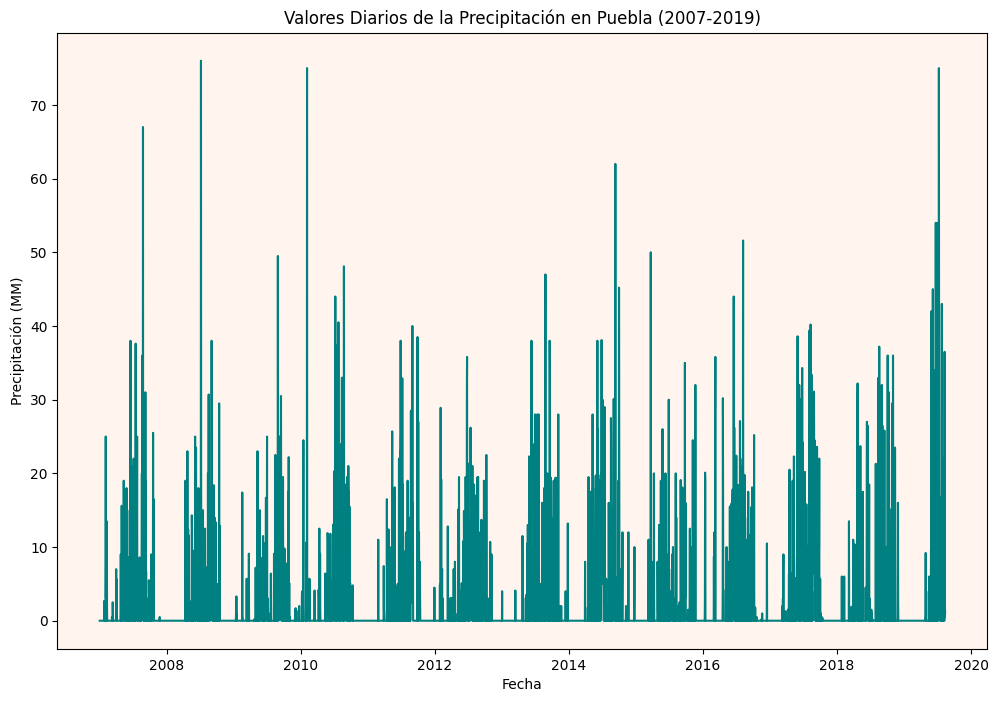

In [10]:
plt.figure(figsize=(12,8))
ax = plt.subplot()

ax.set_facecolor('seashell')
sns.lineplot(x='Fecha',y='Precipitacion',data=datos, c = 'teal')
plt.title('Valores Diarios de la Precipitación en Puebla (2007-2019)')
plt.xlabel("Fecha")
plt.ylabel("Precipitación (MM)")
plt.show()

### Figura 3.2. Visualización de la Evaporación Diaria


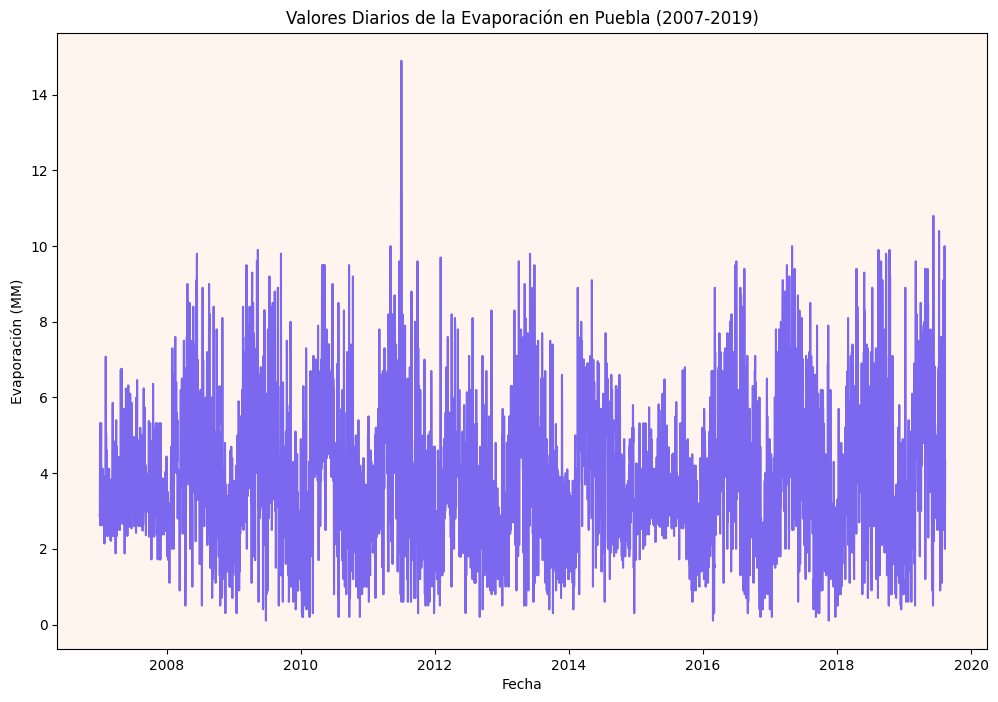

In [11]:
plt.figure(figsize=(12,8))
ax = plt.subplot()

ax.set_facecolor('seashell')
sns.lineplot(x='Fecha',y='Evaporacion',data=datos, c = 'mediumslateblue')
plt.title('Valores Diarios de la Evaporación en Puebla (2007-2019)')
plt.xlabel("Fecha")
plt.ylabel("Evaporación (MM)")
plt.show()

### Figura 3.3. Visualización de la Temperatura Máxima Diaria

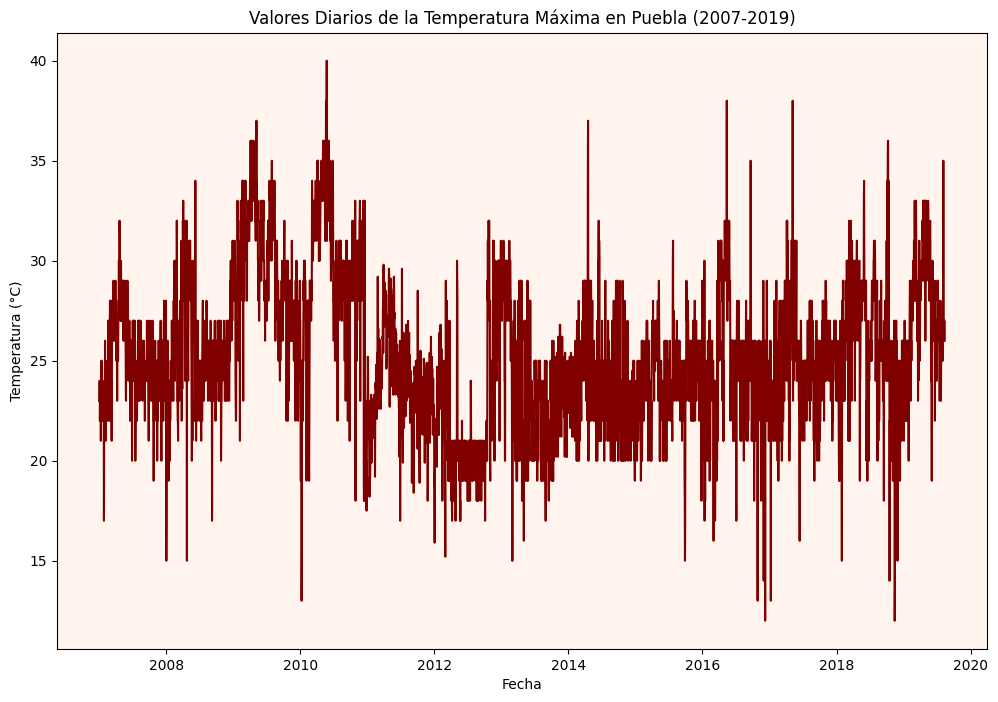

In [12]:
plt.figure(figsize=(12,8))
ax = plt.subplot()

ax.set_facecolor('seashell')
sns.lineplot(x='Fecha',y='TMAX',data=datos, c = 'maroon')
plt.title('Valores Diarios de la Temperatura Máxima en Puebla (2007-2019)')
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.show()

### Figura 3.4. Visualización de la Temperatura Mínima Diaria


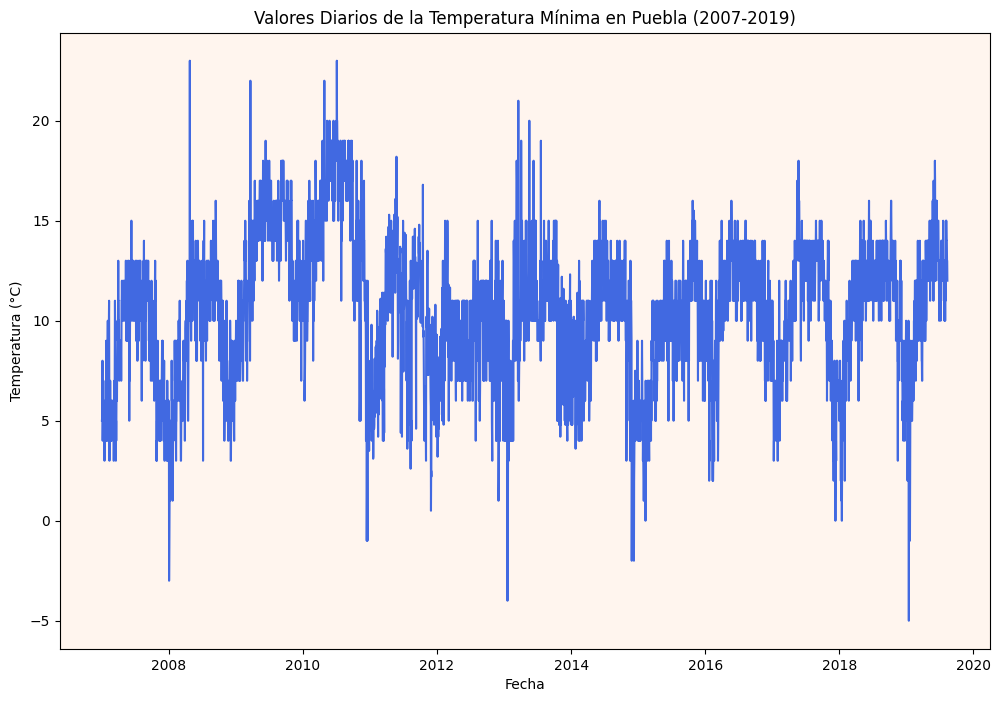

In [13]:
plt.figure(figsize=(12,8))
ax = plt.subplot()

ax.set_facecolor('seashell')
sns.lineplot(x='Fecha',y='TMIN',data=datos, c = 'royalblue')
plt.title('Valores Diarios de la Temperatura Mínima en Puebla (2007-2019)')
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.show()

### Figura 3.5. Visualización de la Media Móvil a 30 Días de las Temperaturas Mínimas y Máximas

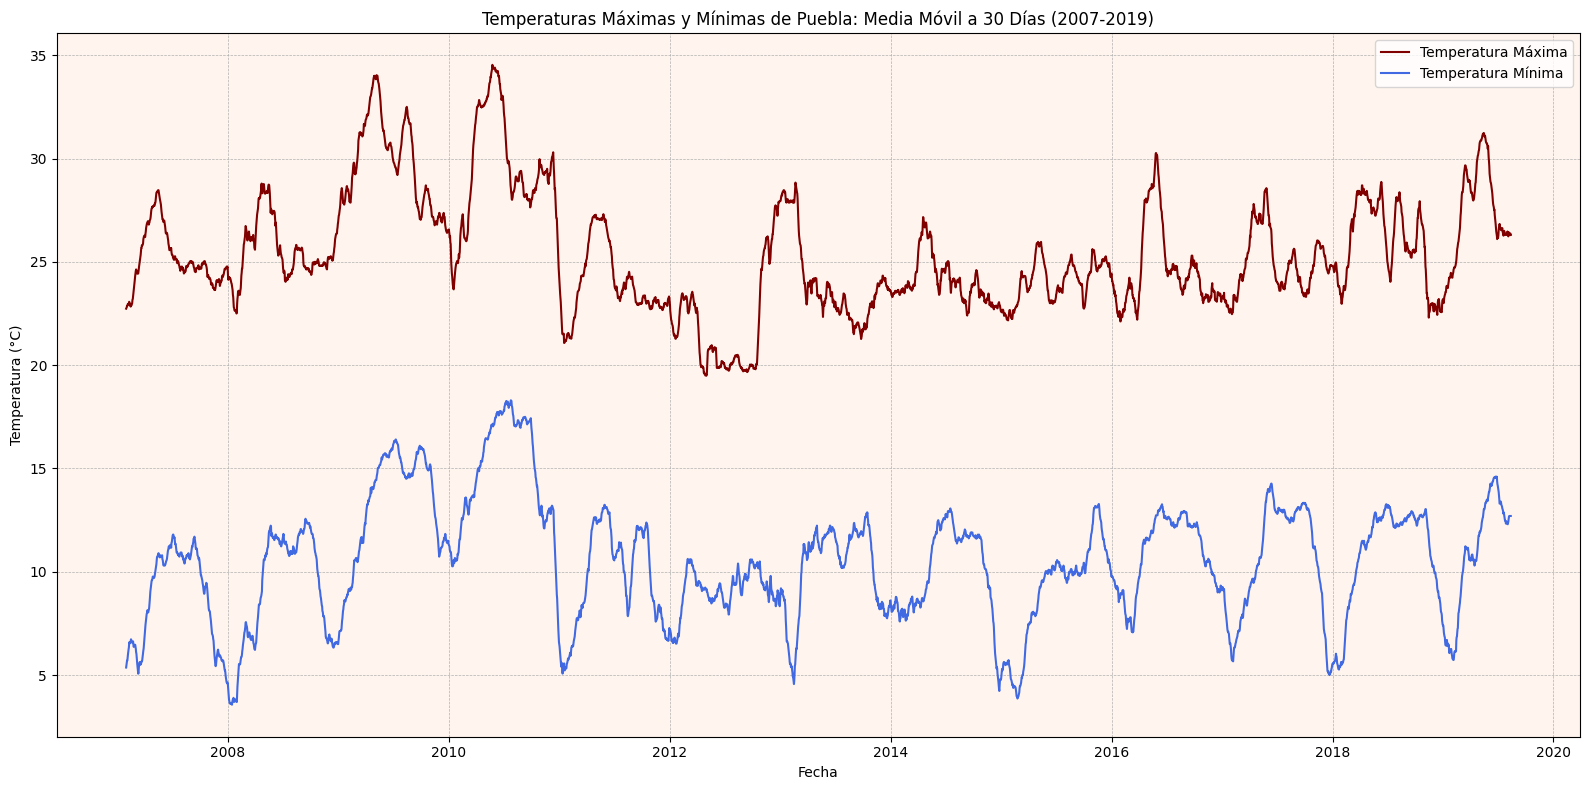

In [14]:
datos_medias = datos.sort_values(by='Fecha')

media_movil_tmax = datos_medias['TMAX'].rolling(window=30).mean()
media_movil_tmin = datos_medias['TMIN'].rolling(window=30).mean()

plt.figure(figsize=(16,8))
ax = plt.subplot()

ax.set_facecolor('seashell')
plt.plot(datos['Fecha'], media_movil_tmax, color='maroon', label='Temperatura Máxima')
plt.plot(datos['Fecha'], media_movil_tmin, color='royalblue', label='Temperatura Mínima')
plt.title('Temperaturas Máximas y Mínimas de Puebla: Media Móvil a 30 Días (2007-2019)')
plt.xlabel('Fecha')
plt.ylabel("Temperatura (°C)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Descomposición de las Series: Tendencia, Estacionalidad y Residuos

In [15]:
# Una vez visualizados los datos, es necesario proceder a encontrar la tendencia, la estacionalidad y los residuos

precip_descomp = seasonal_decompose(datos['Precipitacion'],model='additive',period=365, extrapolate_trend='freq')
evap_descomp = seasonal_decompose(datos['Evaporacion'],model='additive',period=365, extrapolate_trend='freq')
tmax_descomp = seasonal_decompose(datos['TMAX'],model='additive',period=365, extrapolate_trend='freq')
tmin_descomp = seasonal_decompose(datos['TMIN'],model='additive',period=365, extrapolate_trend='freq')

### Figura 4.1. Precipitación en Puebla: Tendencia, Estacionalidad y Residuos

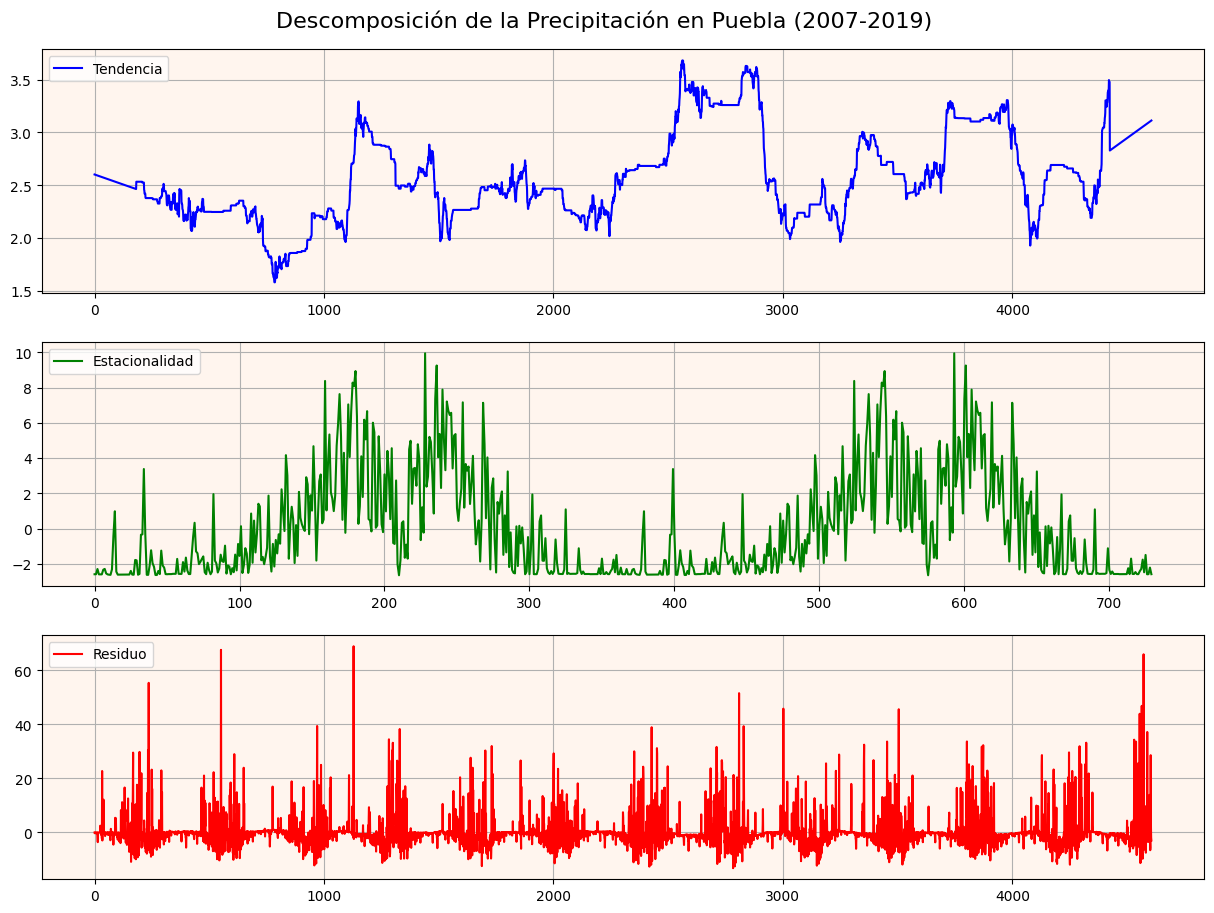

In [16]:
plt.figure(figsize=(15,10))
plt.suptitle('Descomposición de la Precipitación en Puebla (2007-2019)',fontsize=16)


ax1 = plt.subplot(3,1,1)
ax1.set_facecolor('seashell')
plt.plot(precip_descomp.trend,label='Tendencia',color='blue')
plt.legend(loc='upper left')
plt.grid(True)

ax2 = plt.subplot(3,1,2)
ax2.set_facecolor('seashell')
plt.plot(precip_descomp.seasonal.iloc[:365*2],label='Estacionalidad',color='green')
plt.legend(loc='upper left')
plt.grid(True)

ax3 = plt.subplot(3,1,3)
ax3.set_facecolor('seashell')
plt.plot(precip_descomp.resid, label='Residuo', color='red')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(top=0.94)
plt.show()

### Figura 4.2. Evaporación en Puebla: Tendencia, Estacionalidad y Residuos

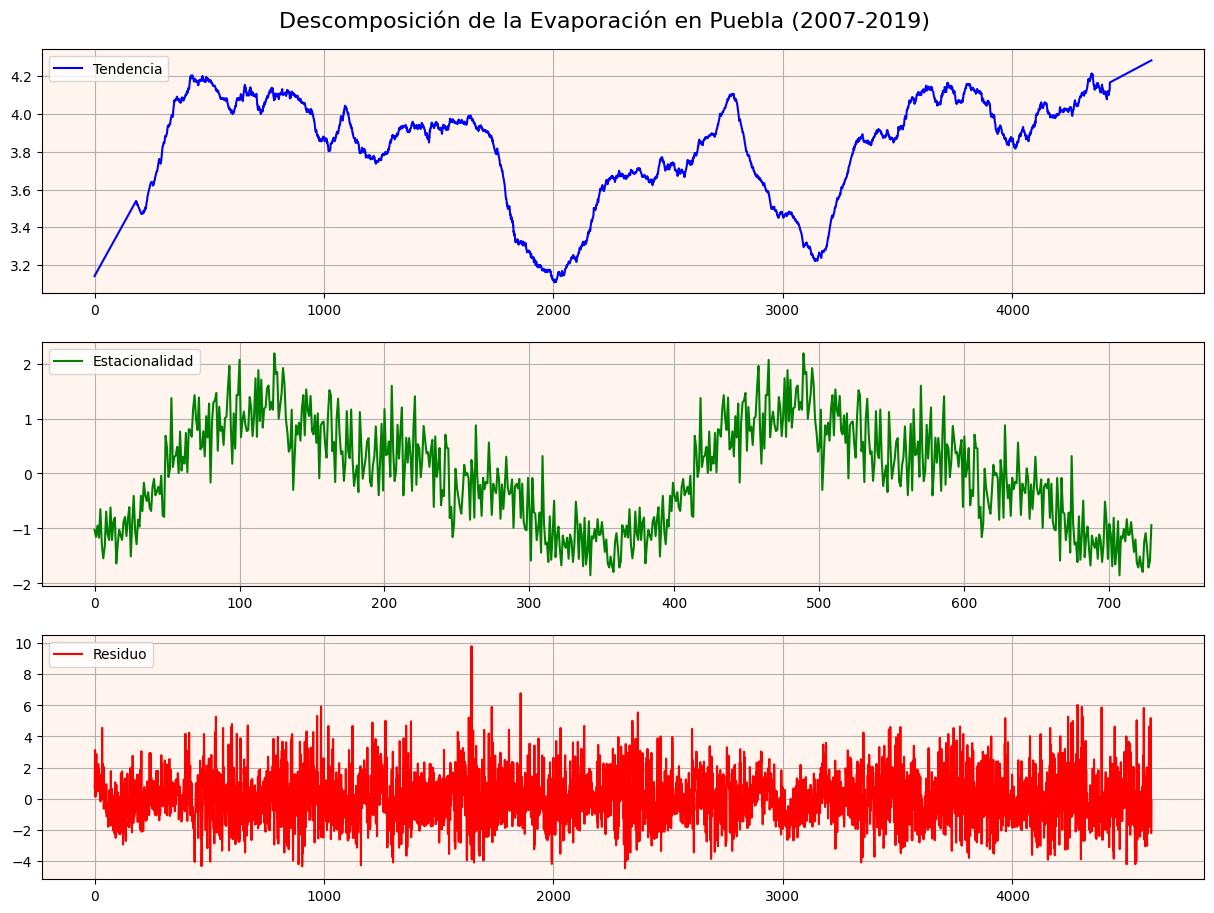

In [17]:
plt.figure(figsize=(15,10))
plt.suptitle('Descomposición de la Evaporación en Puebla (2007-2019)',fontsize=16)


ax1 = plt.subplot(3,1,1)
ax1.set_facecolor('seashell')
plt.plot(evap_descomp.trend,label='Tendencia',color='blue')
plt.legend(loc='upper left')
plt.grid(True)

ax2 = plt.subplot(3,1,2)
ax2.set_facecolor('seashell')
plt.plot(evap_descomp.seasonal.iloc[:365*2],label='Estacionalidad',color='green')
plt.legend(loc='upper left')
plt.grid(True)

ax3 = plt.subplot(3,1,3)
ax3.set_facecolor('seashell')
plt.plot(evap_descomp.resid, label='Residuo', color='red')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(top=0.94)
plt.show()

### Figura 4.3. Temperatura Máxima en Puebla: Tendencia, Estacionalidad y Residuos

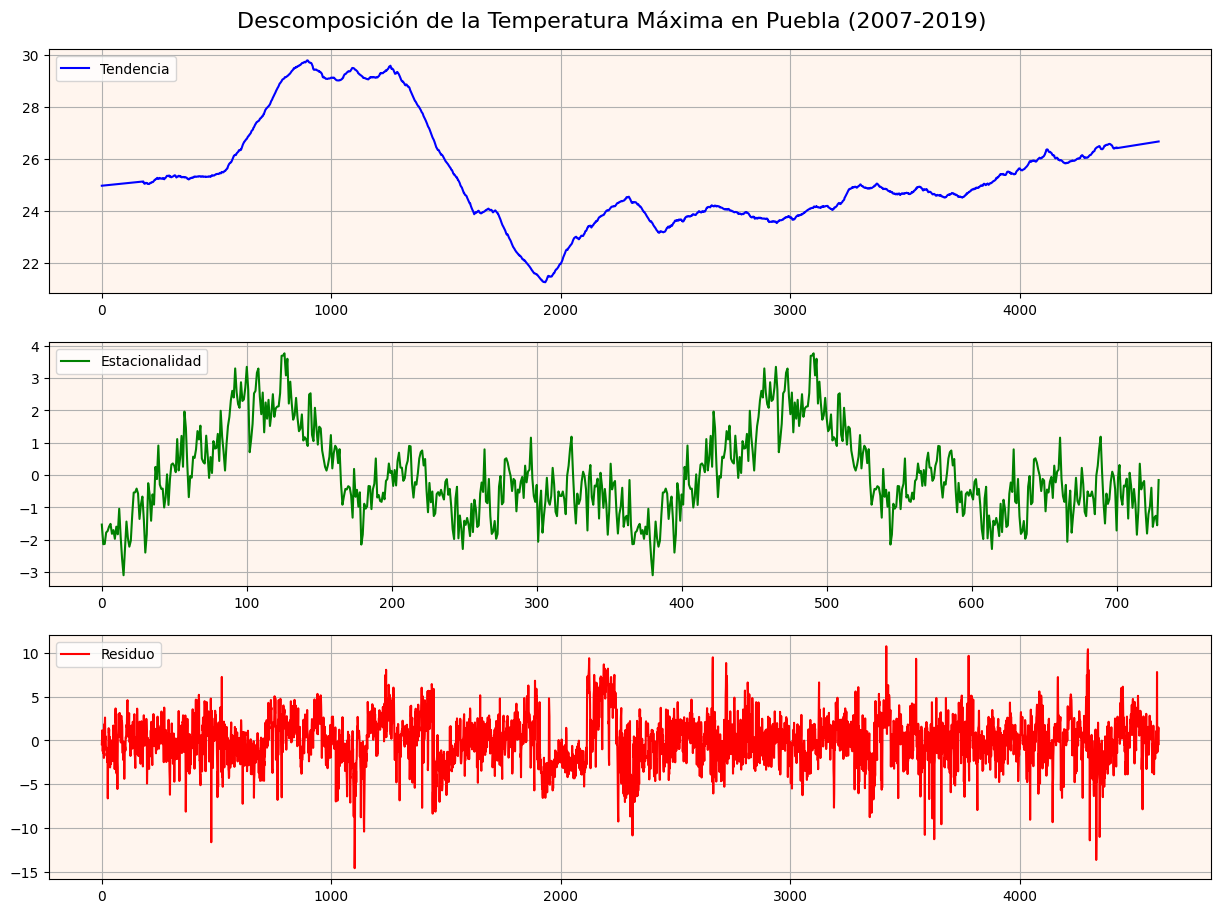

In [18]:
plt.figure(figsize=(15,10))
plt.suptitle('Descomposición de la Temperatura Máxima en Puebla (2007-2019)',fontsize=16)


ax1 = plt.subplot(3,1,1)
ax1.set_facecolor('seashell')
plt.plot(tmax_descomp.trend,label='Tendencia',color='blue')
plt.legend(loc='upper left')
plt.grid(True)

ax2 = plt.subplot(3,1,2)
ax2.set_facecolor('seashell')
plt.plot(tmax_descomp.seasonal.iloc[:365*2],label='Estacionalidad',color='green')
plt.legend(loc='upper left')
plt.grid(True)

ax3 = plt.subplot(3,1,3)
ax3.set_facecolor('seashell')
plt.plot(tmax_descomp.resid, label='Residuo', color='red')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(top=0.94)
plt.show()

### Figura 4.4. Temperatura Mínima en Puebla: Tendencia, Estacionalidad y Residuos

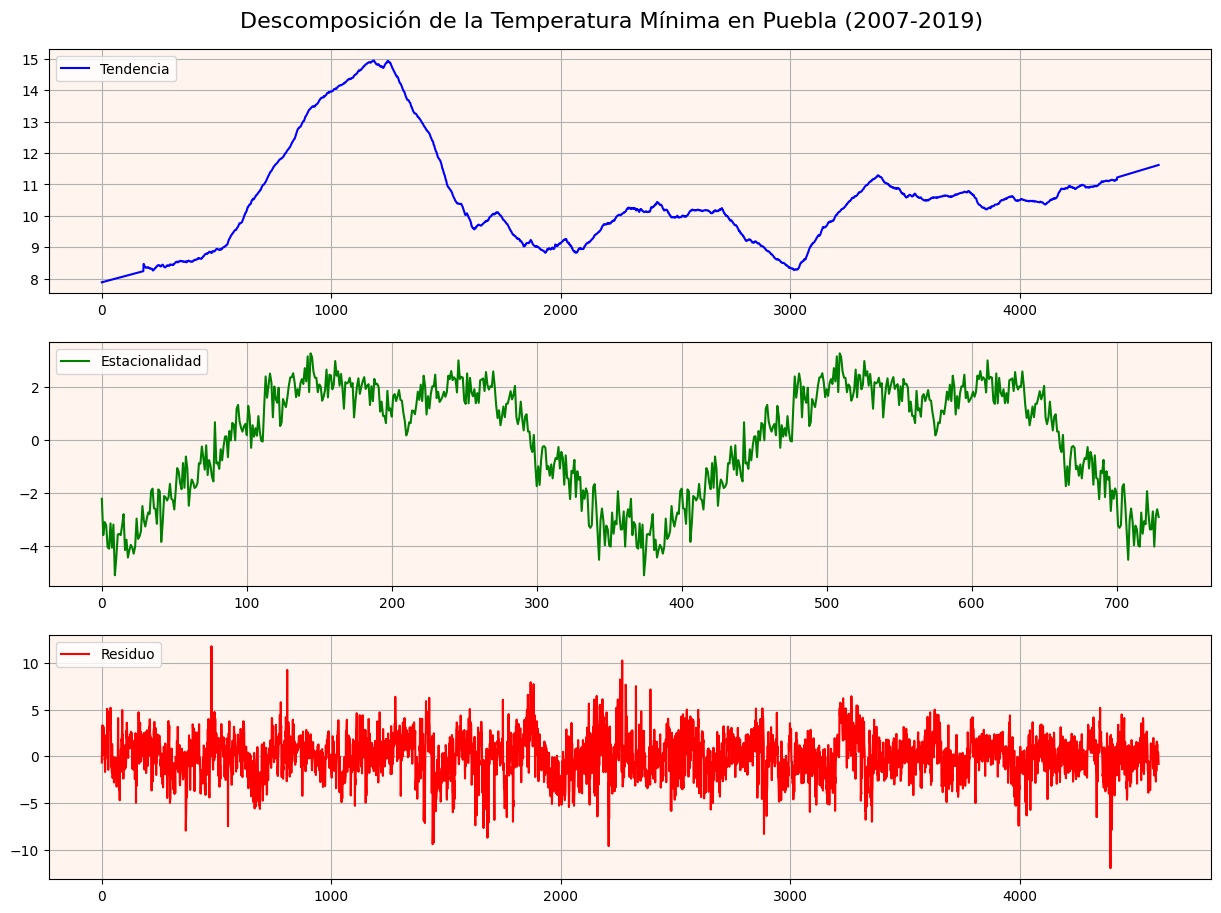

In [19]:
plt.figure(figsize=(15,10))
plt.suptitle('Descomposición de la Temperatura Mínima en Puebla (2007-2019)',fontsize=16)


ax1 = plt.subplot(3,1,1)
ax1.set_facecolor('seashell')
plt.plot(tmin_descomp.trend,label='Tendencia',color='blue')
plt.legend(loc='upper left')
plt.grid(True)

ax2 = plt.subplot(3,1,2)
ax2.set_facecolor('seashell')
plt.plot(tmin_descomp.seasonal.iloc[:365*2],label='Estacionalidad',color='green')
plt.legend(loc='upper left')
plt.grid(True)

ax3 = plt.subplot(3,1,3)
ax3.set_facecolor('seashell')
plt.plot(tmin_descomp.resid, label='Residuo', color='red')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(top=0.94)
plt.show()

## 5. Pronóstico del Clima: Red Neuronal Long-Short Term Memory


In [20]:
# Utilizaremos las medias moviles a 30 dias para realizar el pronostico.

media_movil_precip, media_movil_evap = datos_medias['Precipitacion'].rolling(window=30).mean(), datos_medias['Evaporacion'].rolling(window=30).mean()

# Obtengamos la estacionalidad y la tendencia de los datos de las temp.

stl_tmax = STL(datos['TMAX'], period=365).fit()
tendencia_tmax = stl_tmax.trend
estacionalidad_tmax = stl_tmax.seasonal

stl_tmin = STL(datos['TMIN'], period=365).fit()
tendencia_tmin = stl_tmin.trend
estacionalidad_tmin = stl_tmin.seasonal

datos_rn = pd.concat([media_movil_tmax, media_movil_tmin, media_movil_evap, media_movil_precip,
                      tendencia_tmax, estacionalidad_tmax, tendencia_tmin, estacionalidad_tmin],axis=1)

In [21]:
datos_rn.head(3)

,TMAX,TMIN,Evaporacion,Precipitacion,trend,season,trend,season
0,NaN,NaN,NaN,NaN,24.195723,-1.238562,8.094370,-2.924529
1,NaN,NaN,NaN,NaN,24.199769,-3.815855,8.095602,-6.456743
2,NaN,NaN,NaN,NaN,24.203810,-2.222770,8.096834,-3.833065


In [22]:
# Renombramos las variables trend y seasos; tiramos los NaN

datos_rn.columns = ['TMAX', 'TMIN', 'Evaporacion', 'Precipitacion',
                    'trend_tmax', 'season_tmax', 'trend_tmin', 'season_tmin']

datos_rn = datos_rn.dropna()

datos_rn.head(3)

,TMAX,TMIN,Evaporacion,Precipitacion,trend_tmax,season_tmax,trend_tmin,season_tmin
29,22.733333,5.366667,3.441333,0.093333,24.310716,-1.102963,8.130126,-2.795890
30,22.766667,5.466667,3.476000,0.093333,24.314590,-0.346956,8.131359,-1.143469
31,22.800000,5.600000,3.476000,0.093333,24.318459,0.725227,8.132591,0.830426


In [23]:
# Definimos la X y las y

X = datos_rn[['Precipitacion','Evaporacion',
                    'trend_tmax', 'season_tmax', 'trend_tmin', 'season_tmin']]
y_max = datos_rn['TMAX']
y_min = datos_rn['TMIN']

In [24]:
# Hacemos la separacion de datos

X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.2, random_state=42,shuffle=False)

X_train, X_test, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.2, random_state=42,shuffle=False)

In [25]:
X_train.shape, y_max_train.shape, y_min_train.shape

((3662, 6), (3662,), (3662,))

In [26]:
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))

In [27]:
entrada = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Capas LSTM
x = LSTM(64, activation='tanh', return_sequences=True)(entrada)
x = Dropout(0.2)(x)
x = LSTM(32, activation='tanh', return_sequences=True)(x)
x = Dropout(0.2)(x)

# Capa Dense
x = Dense(32, activation='relu')(x)

# Capas GRU
x = GRU(32, activation='tanh', return_sequences=True)(x)
x = Dropout(0.2)(x)

# Mecanismo de atención
query_value_attention_seq = Attention()([x, x])
x = Concatenate(axis=-1)([x, query_value_attention_seq])

x = Flatten()(x)

# Capas de salida
salida_tmax = Dense(1, name="salida_tmax")(x)
salida_tmin = Dense(1, name="salida_tmin")(x)

modelo = Model(inputs=entrada, outputs=[salida_tmax, salida_tmin])

# Compilamos el Modelo
modelo.compile(optimizer='adam', loss={'salida_tmax':'mse','salida_tmin':'mse'})

parada = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Entrenamos el Modelo
history= modelo.fit(X_train, [y_max_train, y_min_train], epochs=1000, batch_size=32,
                     validation_data=(X_test, [y_max_test, y_min_test]), callbacks=parada)


Epoch 1/1000
115/115 [==============================] - 16s 19ms/step - loss: 423.0481 - salida_tmax_loss: 361.0460 - salida_tmin_loss: 62.0023 - val_loss: 145.2310 - val_salida_tmax_loss: 134.3678 - val_salida_tmin_loss: 10.8631
Epoch 2/1000
115/115 [==============================] - 1s 10ms/step - loss: 80.9186 - salida_tmax_loss: 70.3837 - salida_tmin_loss: 10.5349 - val_loss: 42.3906 - val_salida_tmax_loss: 35.4749 - val_salida_tmin_loss: 6.9157
Epoch 3/1000
115/115 [==============================] - 1s 10ms/step - loss: 33.9345 - salida_tmax_loss: 23.9957 - salida_tmin_loss: 9.9388 - val_loss: 18.0549 - val_salida_tmax_loss: 11.2415 - val_salida_tmin_loss: 6.8134
Epoch 4/1000
115/115 [==============================] - 1s 9ms/step - loss: 25.4350 - salida_tmax_loss: 15.4267 - salida_tmin_loss: 10.0084 - val_loss: 13.1504 - val_salida_tmax_loss: 6.3483 - val_salida_tmin_loss: 6.8021
Epoch 5/1000
115/115 [==============================] - 1s 9ms/step - loss: 24.0314 - salida_tmax_los

In [28]:
# Guardamos el modelo

modelo.save("/mnt/data/modelo_clima.h5")

### Figura 5.1. Pérdida del Modelo

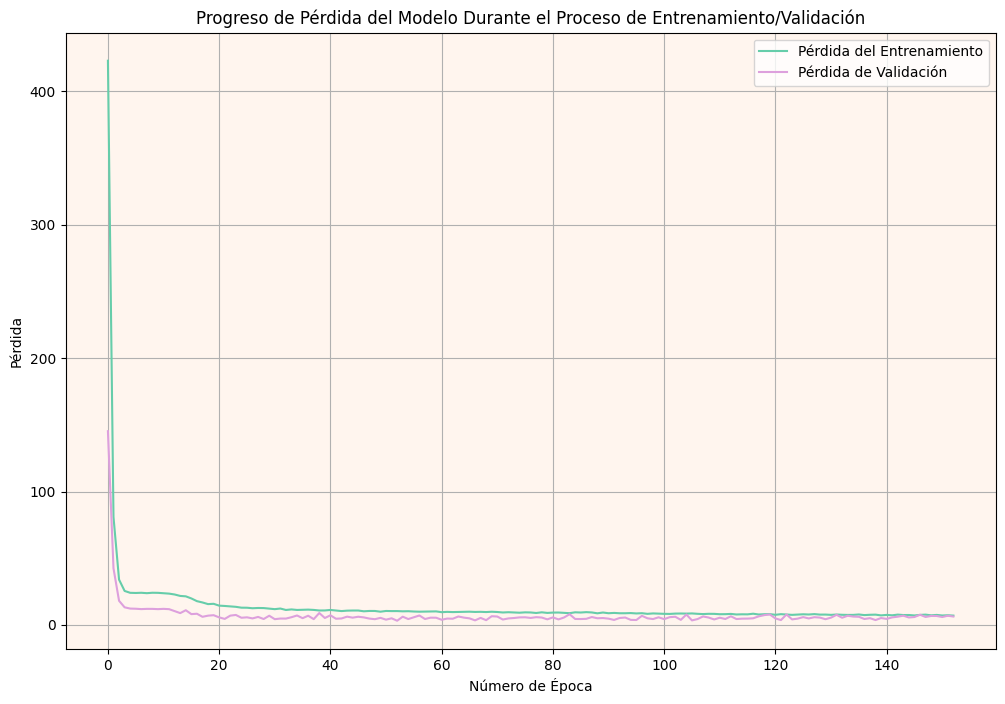

In [29]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()

ax.set_facecolor('seashell')
plt.plot(history.history['loss'], label='Pérdida del Entrenamiento', c='mediumaquamarine')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', c='plum')
plt.title('Progreso de Pérdida del Modelo Durante el Proceso de Entrenamiento/Validación')
plt.ylabel('Pérdida')
plt.xlabel('Número de Época')
plt.legend()
plt.grid(True)
plt.show()

## Figura 5.2. Ajuste del Modelo a las Temperaturas Mínimas y Máximas

29/29 [==============================] - 1s 5ms/step


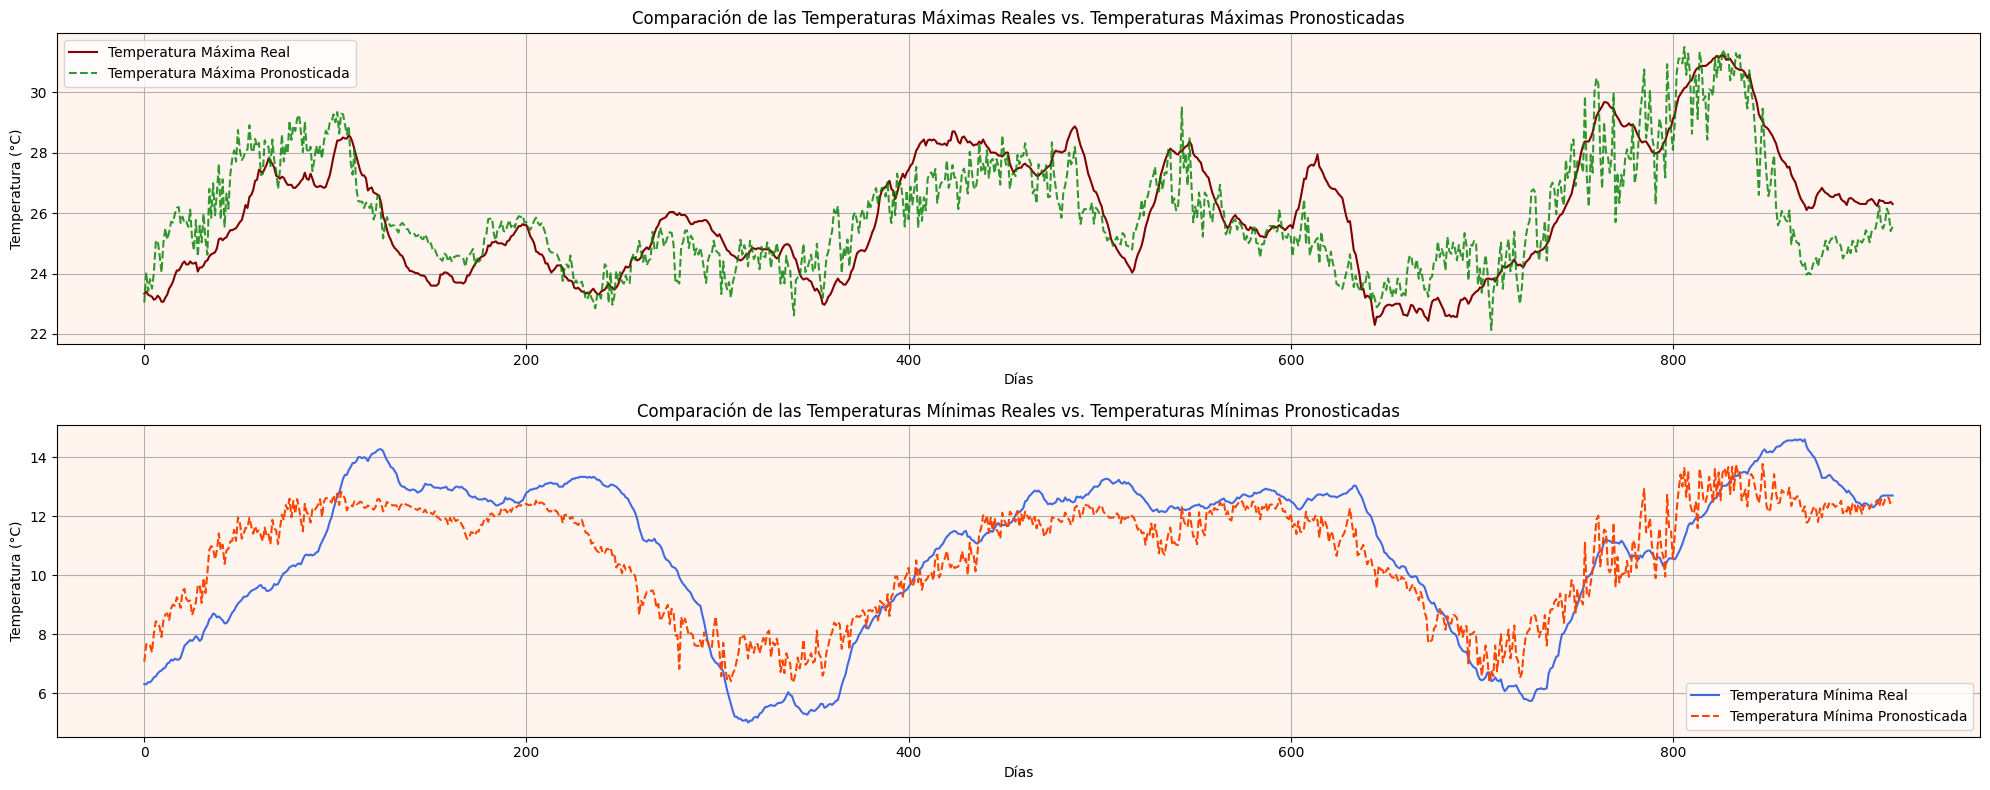

In [30]:
# Datos

real_tmax = media_movil_tmax.values
real_tmin = media_movil_tmin.values


predicciones = modelo.predict(X_test)


predicciones_tmax = predicciones[0]
predicciones_tmin = predicciones[1]

real_tmax = real_tmax.ravel()
predicciones_tmax = predicciones_tmax.ravel()

real_tmin = real_tmin.ravel()
predicciones_tmin = predicciones_tmin.ravel()


total_tmax = np.concatenate((real_tmax, predicciones_tmax))
total_tmin = np.concatenate((real_tmin, predicciones_tmin))


real_tmax = real_tmax.ravel()
predicciones_tmax = predicciones_tmax.ravel()

real_tmin = real_tmin.ravel()
predicciones_tmin = predicciones_tmin.ravel()


total_tmax = np.concatenate((real_tmax, predicciones_tmax))
total_tmin = np.concatenate((real_tmin, predicciones_tmin))

# Grafico
plt.figure(figsize=(20, 8))

# TMAX
ax1 = plt.subplot(2, 1, 1)
ax1.set_facecolor('seashell')
plt.plot(real_tmax[-len(predicciones_tmax):], label="Temperatura Máxima Real", color="maroon")
plt.plot(predicciones_tmax,  label="Temperatura Máxima Pronosticada", color="green", linestyle="--",
         alpha=0.8)
plt.legend()
plt.title("Comparación de las Temperaturas Máximas Reales vs. Temperaturas Máximas Pronosticadas")
plt.xlabel("Días")
plt.ylabel("Temperatura (°C)")
plt.grid(True)

# TMIN
ax2 = plt.subplot(2, 1, 2)
ax2.set_facecolor('seashell')
plt.plot(real_tmin[-len(predicciones_tmin):], label="Temperatura Mínima Real", color="royalblue")
plt.plot(predicciones_tmin, label="Temperatura Mínima Pronosticada", color="orangered", linestyle="--")
plt.legend()
plt.title("Comparación de las Temperaturas Mínimas Reales vs. Temperaturas Mínimas Pronosticadas")
plt.xlabel("Días")
plt.ylabel("Temperatura (°C)")
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Conclusión

Predecir el clima es una tarea extremadamente compleja, sin embargo, el presente ejercicio sirvió como un mecanismo para aprender acerca del raspado de datos en internet, así como la creación de redes neuronales para el pronóstico de valores. Como se puede observar en la Figura 5.2., el modelo no predice perfectamente los valores, pero logra generalizar lo suficiente para acercarse de manera satisfactorio en cada punto de la serie de tiempo.


> En este sentido, si el lector desease pronosticar las temperaturas máximas y mínimas en la ciudad de Puebla, únicamente necesitaría la evaporación y precipitación pronosticada (en milimetros), así como la tendencia y estacionalidad de las temperaturas mínimas y máximas, lo cual se puede obtener mediante un modelo ARIMA.

